<a href="https://colab.research.google.com/github/ugurtegin/Nonlinear_MMF_Network/blob/main/Simulations/BPM_sinc_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries


In [1]:
####Open in Colab not working yet


!cd '/Users/mcroning/Anaconda'   
import numpy as np
from numpy.linalg import matrix_power
#import cupy as cp
import matplotlib.pyplot as plt
import scipy.io as sio
import time
import ray

import cProfile, pstats
import hub
import tqdm
filepath="/Users/mcroning/Anaconda/"
from scipy.io import savemat,loadmat
from scipy.sparse import diags
from scipy.linalg import block_diag
import keras
import json
###
#import tensorflow.linalg as tfl
#import tensorflow as tf
import scipy as sp
import scipy.sparse as sparse
from scipy.ndimage import zoom,gaussian_filter 
from scipy.linalg import solve_banded,solveh_banded
from scipy import signal
import scipy.fft
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
ray.shutdown()



ray.init(
    _system_config={
        # Allow spilling until the local disk is 99% utilized.
        # This only affects spilling to the local file system.
        "local_fs_capacity_threshold": 0.99,
        "object_spilling_config": json.dumps(
            {
              "type": "filesystem",
              "params": {
                "directory_path": "/tmp/spill",
            },
    
    },
)})





/Users/mcroning/miniforge3/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.3.2) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
2023-04-28 13:09:16,133	INFO worker.py:1538 -- Started a local Ray instance.


Python version:,3.9.10
Ray version:,2.2.0


In [2]:
class res:
    def __init__(self, imout, intensxz, amp, amp0):
        self.imout = imout
        self.intensxz = intensxz
        self.amp = amp
        self.amp0=amp0

    

#effective electrooptic coefficient
###reff=2*gl*lm/(rlen*np.pi*refin**3*Es)


@ray.remote
def prtrans(arrin,prdata):
   
    def gaus(x,y,z,transp,arrin,prdata):       
        lm=prdata['lm']
        rlen=prdata['rlen']
        refin=prdata['refin']
        w01=prdata['w01']
        w02=prdata['w02']
        refin=prdata['refin']
        xsamp=prdata['xsamp']
        ysamp=prdata['ysamp']
        xaper=prdata['xaper']
        yaper=prdata['yaper']
        dx=xaper/xsamp
        dy=yaper/ysamp
        thout1=prdata['thout1']
        thout2=prdata['thout2']
        th1=np.arcsin(np.sin(thout1)/refin)
        th2=np.arcsin(np.sin(thout2)/refin)
        x1=rlen*np.tan(th1)/2 #twice the axis rotationaxis z location from mathematica
        kout=2*np.pi/lm
        kin=refin*kout
        z0x=w01**2*kin/2.0
        z0y=w02**2*kin/2.0
        eta=(np.arctan(z/z0x)+np.arctan(z/z0y))/2
        rlxinv=z/(z**2+z0x**2)
        rlyinv=z/(z**2+z0y**2)
        rlxinvmn=rlen/(rlen**2+z0x**2) #mean radius of curvature
        wl2x=w01**2*(1.0+(z/z0x)**2)
        wl2y=w02**2*(1.0+(z/z0y)**2)
        wlxy=np.sqrt((1.0+(z/z0x)**2)*(1.0+(z/z0y)**2))
        xmax=np.pi/(kin*dx*rlxinvmn)
        amp1 = np.zeros((xsamp,ysamp),dtype='complex')
        argx = (x**2)*(1.0/wl2x-1j*kin*rlxinv/2.0)
        argy = (y**2)*(1.0/wl2y-1j*kin*rlyinv/2.0)
        arg=argx+argy
        amp1 = np.where(np.real(arg)<15.0,np.exp(-arg+1j*kin*z-1j*eta)/np.sqrt(wlxy),0)
        #amp1 = wt*np.exp(-arg-1j*kin*z-1j*eta)/np.sqrt(wlxy) #switch to -j k z for wide angle
        padleftx=(xsamp-np.shape(arrin)[0])//2
        padrightx=xsamp-padleftx-np.shape(arrin)[0]
        padlefty=(ysamp-np.shape(arrin)[1])//2
        padrighty=ysamp-padlefty-np.shape(arrin)[1]

        # beam may have the data transparency imposed
        if transp == 1:
            arrin_cp=np.pad(arrin,((padleftx,padrightx),(padlefty,padrighty)),mode='constant')
            arrin_cp.resize(np.shape(amp1))        
            amp1=amp1*np.roll(arrin_cp,(int(x1/np.cos(th1)*xsamp/xaper),0),axis=[0,1])
        return amp1
    
    def a(arrin,prdata,offset):
        #offset True then shift z by delta z for derivative d/dz calc
        rat=prdata['rat']
        a1r=1.0/np.sqrt(1.0+rat)
        a2r=np.sqrt(rat)/np.sqrt(1.0+rat)       
        xp1=prdata['xp1']
        yp1=prdata['yp1']
        zp1=prdata['zp1']
        xp2=prdata['xp2']
        yp2=prdata['yp2']
        zp2=prdata['zp2']
        xp1dz=prdata['xp1dz']
        yp1dz=prdata['yp1dz']
        zp1dz=prdata['zp1dz']
        xp2dz=prdata['xp2dz']
        yp2dz=prdata['yp2dz']
        zp2dz=prdata['zp2dz']

        transp1=prdata['transp1']
        transp2=prdata['transp2']
        if offset==False:
            amp1=gaus(xp1,yp1,zp1,transp1,arrin,prdata)
            amp2=gaus(xp2,yp2,zp2,transp2,arrin,prdata)
        else:
            amp1=gaus(xp1dz,yp1dz,zp1dz,transp1,arrin,prdata)
            amp2=gaus(xp2dz,yp2dz,zp2dz,transp2,arrin,prdata)    
        
        atot=a1r*amp1+a2r*amp2 
        return atot
    
    def esc(intens,prdata):  #unused, to reduce overhead
        fx1=np.linspace(0,(xsamp/2-1)/(xaper),int(xsamp/2))
        fx2=np.linspace(-xsamp/2/(xaper),-1.0/xaper,int(xsamp/2))
        fx=np.concatenate((fx1,fx2))
        
        #fy1=np.linspace(0,(ysamp/2-1)/(yaper),int(ysamp/2))
        #fy2=np.linspace(-ysamp/2/(yaper),-1.0/yaper,int(ysamp/2))
        #fy=np.concatenate((fy1,fy2))
        fxx=np.tile(fx,(ysamp,1)).T
        NT=prdata['NT']
        epsr=prdata['epsr']
        eps0=prdata['eps0']
        kB=prdata['kB']
        T=prdata['T']
        k0=q*np.sqrt(NT/(epsr*eps0*kB*T))*1e-6
        
        Id=prdata['Id']
        Ip=np.real(scipy.fft.ifft(1.0j*2*np.pi*fxx*scipy.fft.fft(intens,axis=0),axis=0))/k0
        Ip.astype(float)
        Esc=scipy.fft.ifft(-scipy.fft.fft(Ip/(intens+Id),axis=0)/(1+(2.0*np.pi*fxx/k0)**2),axis=0) #fxx instead of fxy
        return Esc 
    
    mode=prdata['mode'] 
    rlen=prdata['rlen']
    lm=prdata['lm']  #wavelength
    refin=prdata['refin'] #refractive index
    kout=2*np.pi/lm      #external wavenumber
    kin=refin*kout
    #prdata=ray.get(prdata_id)
    imsize=prdata['imsize']
    zoomsc=prdata['data_in_size']/imsize
    xsamp=prdata['xsamp']
    ysamp=prdata['ysamp']
    thout1=prdata['thout1']
    thout2=prdata['thout2']
    windowedge=prdata['windowedge']
    gl=prdata['gl']
    fx1=np.linspace(0,(xsamp/2-1)/(xaper),int(xsamp/2))
    fx2=np.linspace(-xsamp/2/(xaper),-1.0/xaper,int(xsamp/2))
    fx=np.concatenate((fx1,fx2))
        
    #fy1=np.linspace(0,(ysamp/2-1)/(yaper),int(ysamp/2))
    #fy2=np.linspace(-ysamp/2/(yaper),-1.0/yaper,int(ysamp/2))
    #fy=np.concatenate((fy1,fy2))
    fxx=np.tile(fx,(ysamp,1)).T  #tiled x frequencies
    
    #fxy=prdata['fxy']
    
    Id=prdata['Id']

    th1=np.arcsin(np.sin(thout1)/refin)
    th2=np.arcsin(np.sin(thout2)/refin)
    
    h=prdata['h']
    refin=prdata['refin']
    NT=prdata['NT']
    epsr=prdata['epsr']
    eps0=prdata['eps0']
    kB=prdata['kB']
    T=prdata['T']
    q=prdata['q']
    k0=q*np.sqrt(NT/(epsr*eps0*kB*T))*1e-6 #characteristic photorefractive wavenumber
    Es=q*NT/(epsr*eps0*k0*1e6)             #characteristic space charge field
    th1=np.arcsin(np.sin(thout1)/refin)
    th2=np.arcsin(np.sin(thout2)/refin)
    alpha=0
    dz=prdata['dz']
    niter=int(rlen/dz)
    noiseamp=prdata['noiseamp']
    #corrnoise=prdata['corrnoise']
    #corrnoise1layer=prdata['corrnoise1layer']
    
    
    windowx = signal.windows.tukey(xsamp,alpha=windowedge)
    windowy = signal.windows.tukey(ysamp,alpha=windowedge)
    windowxy=np.outer(windowx,windowy)
    fwindowxy=np.fft.fftshift(windowxy)
    
    dx=xaper/xsamp
    dy=yaper/ysamp
   
    amp0=np.zeros((xsamp,ysamp),dtype="complex")
    ampp=np.zeros((xsamp,ysamp),dtype="complex")
    ampm=np.zeros((xsamp,ysamp),dtype="complex")
    onesxy=np.ones((xsamp,ysamp),dtype="complex")

    fp=np.append(np.zeros((xsamp//2,ysamp)),np.ones((xsamp//2,ysamp)),axis=0)
    fm=np.append(np.ones((xsamp//2,ysamp)),np.zeros((xsamp//2,ysamp)),axis=0)
   
    amp0=a(arrin,prdata,False)
    #amp0=amp0*np.exp(noiseamp*2*np.pi*1.0j*corrnoise1layer*rlen) #1layer noise
    amp=amp0*1.0
 
    amppz1=1j*kin*amp #amplitude derivative 
    dz_small=lm/refin*prdata['dz_frac']
    amppz=(a(arrin,prdata,True)-amp0)/dz_small #more accurate amplitude derivative
    
   
    #for speed generate noise in program, not from corrnoise stored in prdata
    rng=np.random.default_rng(12345) #fix seed
    corrnoise=np.zeros((xsamp,ysamp))
    sigma=prdata['sigma']
    sigmax=sigma/dx
    sigmay=sigma/dy
    escsxz=np.zeros((niter,xsamp))
    intensxz=np.zeros((niter,xsamp))

    
    if mode =='fdbpm':
        gLx=np.zeros(xsamp-2)
        gRx=np.zeros(xsamp-2)
        gLy=np.zeros(ysamp-2)
        gRy=np.zeros(ysamp-2)
        a1=-np.ones(xsamp-2,dtype='complex')
        c1=-np.ones(xsamp-2,dtype='complex')
        cd1=np.ones(xsamp-2,dtype='complex')
        b1=np.zeros(xsamp-2,dtype='complex')
        q1=np.zeros(xsamp-2,dtype='complex')
        d1=np.zeros(xsamp-2,dtype='complex')
        c1[0]=0
        a1[-1]=0
        ab1=[c1,b1,a1]
        a2=-np.ones(ysamp-2,dtype='complex')
        c2=-np.ones(ysamp-2,dtype='complex')
        cd2=np.ones(ysamp-2,dtype='complex')
        b2=np.zeros(ysamp-2,dtype='complex')
        q2=np.zeros(ysamp-2,dtype='complex')
        d2=np.zeros(ysamp-2,dtype='complex')
        c2[0]=0
        a2[-1]=0
        ab2=[c2,b2,a2]
        ##amp=amp0*np.exp(noiseamp*2*np.pi*1.0j*corrnoise[0,:]*dz) #multilayer noise

        for i in range(niter):
            corrnoise=rng.random((xsamp,ysamp))-0.5
            corrnoise=gaussian_filter(corrnoise,sigma=(sigmax,sigmay))
            
            intens2=abs(amp)**2
            #ft in x only
            Ip=np.real(scipy.fft.ifft(1.0j*2*np.pi*fxx*scipy.fft.fft(intens2,axis=0),axis=0))/k0
            escs=scipy.fft.ifft(-scipy.fft.fft(Ip/(intens2+Id),axis=0)/(1+(2.0*np.pi*fxx/k0)**2),axis=0) # escs_norm fxx instead of fxy
            dn= -escs*refin*2*gl/(rlen*kout)+noiseamp*corrnoise

            A1=amp*1.0
            A2=A1*1.0
            A3=A2*1.0
            #pass 1
            for m in range(1,ysamp-1):
                b1=2-1j*(4*kin*dx**2/dz  +kin*dx**2*alpha )*cd1  -(kin*dx)**2/2*(2*dn[1:-1,m]+dn[1:-1,m]**2/refin**2)
                q1=-2-1j*(4*kin*dy**2/dz -kin*dy**2*alpha )*cd1 +(kin*dy)**2/2*(2*dn[1:-1,m]+dn[1:-1,m]**2/refin**2)
                d1=(dx/dy)**2*(A1[1:-1,m-1]+q1*A1[1:-1,m]+A1[1:-1,m+1])
                #gL=A1[1,m]/A1[2,m]
                #gR=A1[-2,m]/A1[-3,m]
                ab1[1]=b1
                A2[1:-1,m]=solve_banded((1,1),ab1,d1)
                #A2[0,m]=gL*A2[1,m]
                #A2[-1,m]= gR*A2[-2,m]

            A3=A2*1.0
            #pass 2
            for ii in range(1,xsamp-1):
                b2=2-1j*(4*kin*dy**2/dz  +kin*dy**2*alpha  )*cd2  -(kin*dy)**2/2*(2*dn[ii,1:-1]/refin+dn[ii,1:-1]**2/refin**2)  
                q2=-2-1j*(4*kin*dx**2/dz -kin*dx**2*alpha  )*cd2  +(kin*dx)**2/2*(2*dn[ii,1:-1]/refin+dn[ii,1:-1]**2/refin**2)
                #d2=-(dx/dy)**2*(A2[0:-2,m]+q2*A2[1:-1,m]+A2[2:,m])
                d2=(dy/dx)**2*(A2[ii-1,1:-1]+q2*A2[ii,1:-1]+A2[ii+1,1:-1])
                #gL=A2[1,m]/A2[2,m]
                #gR=A2[-2,m]/A2[-3,m]
                ab2[1]=b2
                A3[ii,1:-1]=solve_banded((1,1),ab2,d2)
                #A3[0,m]=gL*A3[1,m]
                #A3[-1,m]= gR*A3[-2,m]

            amp[1:-1,1:-1]=A3[1:-1,1:-1]
                #amp[0,1:-1]=amp[1,1:-1]*gLy #bc
                #amp[-1,1:-1]=amp[-2,1:-1]*gRy #bc   
    #            ampp=np.fft.ifft2(np.fft.fft2(amp)*fp)
    #            ampm=np.fft.ifft2(np.fft.fft2(amp)*fm)
            intensxz[i,:]=abs(amp[:,(ysamp//2)])**2  ##temp
            escsxz[i,:]=escs[:,ysamp//2]

    elif mode=='fft':

            for i in range(niter):
                fwindowxy=np.fft.fftshift(windowxy)
                corrnoise=rng.random((xsamp,ysamp))-0.5
                corrnoise=gaussian_filter(corrnoise,sigma=(sigmax,sigmay))
                ##prop function here
                amp=scipy.fft.fft2(amp)*h*fwindowxy # fwindowxy
                amp=scipy.fft.ifft2(amp)
                intens2=abs(amp)**2

                ####Ip=np.real(scipy.fft.ifft2(1.0j*2*np.pi*fxx*scipy.fft.fft2(intens2)))/k0            
                ####escs=scipy.fft.ifft2(-scipy.fft.fft2(Ip/(intens2+Id))/(1+(2.0*np.pi*fxx/k0)**2)) # escs_norm fxx instead of fxy


                Ip=np.real(scipy.fft.ifft(1.0j*2*np.pi*fxx*scipy.fft.fft(intens2,axis=0),axis=0))/k0
                escs=scipy.fft.ifft(-scipy.fft.fft(Ip/(intens2+Id),axis=0)/(1+(2.0*np.pi*fxx/k0)**2),axis=0) # escs_norm fxx instead of fxy
                ##escs=escs*(1.0+noiseamp*corrnoise[i,:])  ###new
                #escs=esc(intens2,prdata)*Es


        # zeroed out 3D distributed noise
                dn= -escs*refin*2*gl/(rlen*kout)+noiseamp*corrnoise
                
                #phn= -escs*refin*2*gl/(rlen)
                #amp=amp*np.exp(1.0j*phn*dz+noiseamp*1.0j*corrnoise[i,:]*dz) # distributed noise
                amp=amp*np.exp(1.0j*kin*dn*dz)
                amp=amp*windowxy

                intensxz[i,:]=abs(amp[:,(ysamp//2)])**2  ##temp
                escsxz[i,:]=escs[:,int(ysamp/2)]
#### wide angle code
    elif mode=='fdbpm nonparaxial':
           
            diagnostic=False
            if diagnostic:
                
                w0=prdata['w01']
                
                xs=np.linspace(-xaper/2,xaper/2,xsamp)
                ys=np.linspace(-yaper/2,yaper/2,ysamp)
                z0=0
                th1=np.arcsin(np.sin(thout1)/refin)
                x1=rlen*np.tan(th1)/2 #twice the axis rotationaxis z location from mathematica
                Psix=np.zeros((xsamp,ysamp),dtype=complex)
                Psixp=np.zeros((xsamp,ysamp),dtype=complex)
                dnxz=np.zeros((xsamp,niter))
                dn=np.zeros((xsamp,ysamp))
                #kin=prdata['refin']*2*np.pi/prdata['lm']
                kx=kin*np.sin(th1)
                kz=kin*np.sqrt(1-(kx/kin)**2)
            
                for i in range(xsamp):

                    for j in range(ysamp):
           
                #dn[i,j]=np.where(abs(xs[i]+x1)**2+(ys[j]**2)<(2*w0)**2,0.1,0)*0.2
                #dnxz[i,:]=dn[i,ysamp//2]
                        Psix[i,j]=np.exp(-((xs[i]-x1)**2+(ys[j]**2))/w0**2)*np.exp(1j*(+kx*(xs[i]+x1)+kz*z0))
                        #Psix[i,j]=Psix[i,j]+np.exp(-((xs[i]-x1)**2+ys[j]**2)/w0**2)*np.exp(1j*(-kx*(xs[i]+x1)+kz*z0))
                        Psixp[i,j]=(1j*kz*Psix[i,j])
            else:
                Psix=amp
                Psixp=amppz

            Psix0=Psix
            Psiy=Psix.T
            Psiyp=Psixp.T
            Psiy0=Psiy
            amp0=Psix
            amp=Psix
            dn=np.zeros((xsamp,ysamp))  # placeholder
            Px=prdata['Px']
            Py=prdata['Py']
            Px11=Px[0,0]
            Px12=Px[0,1]
            Px21=Px[1,0]
            Px22=Px[1,1]
            Py11=Py[0,0]
            Py12=Py[0,1]
            Py21=Py[1,0]
            Py22=Py[1,1]
            A=prdata['A']
            ###Psix=amp
            ###Psixp=amppz
            ###Psiy=amp.T
            ###Psiyp=Psixp.T
            loc=prdata['loc']
            if loc=='PyPx':
                for j in range(niter):
                    intens2=abs(Psix)**2
                    Ip=np.real(scipy.fft.ifft(1.0j*2*np.pi*fxx*scipy.fft.fft(intens2,axis=0),axis=0))/k0
                    escs=scipy.fft.ifft(-scipy.fft.fft(Ip/(intens2+Id),axis=0)/(1+(2.0*np.pi*fxx/k0)**2),axis=0) # escs_norm fxx instead of fxy
                    dn= escs*refin*2*gl/(rlen*kout)+noiseamp*corrnoise


        # zeroed out 3D distributed noise
                    Psiy1=Psix.T  #temp holder for Psiy
                    Psiyp1=Psixp.T #temp holder for Psiyp
                    Psiy=(Py11@Psiy1+Py12@Psiyp1)  #Py operates on PSIy to produce Psiy
                    Psiyp=(Py21@Psiy1+Py22@Psiyp1) #Py operates on PSIy to producce Psiyp
                    Psix1=Psiy.T   #temp holder for Psix
                    Psixp1=Psiyp.T #temp holder for Psiy
                    Psix=(Px11@Psix1+Px12@Psixp1) #Px operates on PSIx to produce Psix
                    Psixp=(Px21@Psix1+Px22@Psixp1) #+ 2*kin**2*dn/n0*dz*Psix 
                    nx=np.exp(-1j*kin*dn*dz)
                    Psix=Psix*nx
                    #Psix=Psix*nx*windowxy #edge window Psix and Psixp
                    Psixp=(Psixp-1j*dn*kin*Psix)*nx  #temp remove window
                    #Psixp=(Psixp-1j*dn*kin*Psix)*nx*windowxy
                    intensxz[j,:]= abs(Psix[:,ysamp//2])**2 #temporary diagnostics
                    escsxz[j,:]=dn[:,int(ysamp/2)]          #temporary diagnostics
                
            elif loc=='PyQx':
                for j in range(niter):
                    intens2=abs(Psix)**2
                    Ip=np.real(scipy.fft.ifft(1.0j*2*np.pi*fxx*scipy.fft.fft(intens2,axis=0),axis=0))/k0
                    escs=scipy.fft.ifft(-scipy.fft.fft(Ip/(intens2+Id),axis=0)/(1+(2.0*np.pi*fxx/k0)**2),axis=0) # escs_norm fxx instead of fxy
                    dn= escs*refin*2*gl/(rlen*kout)+noiseamp*corrnoise
        # zeroed out 3D distributed noise
        
                    Psiy1=Psix.T  #temp holder for Psiy
                    Psiyp1=Psixp.T #temp holder for Psiyp
                    Psiy=(Py11@Psiy1+Py12@Psiyp1)  #Py operates on PSIy to produce Psiy
                    Psiyp=(Py21@Psiy1+Py22@Psiyp1) #Py operates on PSIy to producce Psiyp               
                    Psiyp=-Psiy@A*dz-2*kout**2*refin*dn.T*dz+Psiyp
                    
                    Psix=Psiy.T   
                    Psixp=Psiyp.T              
                    intensxz[j,:]= abs(Psix[:,ysamp//2])**2 #temporary diagnostics
                    escsxz[j,:]=dn[:,int(ysamp/2)]          #temporary diagnostics
                
            amp=Psix
            
        #######        

                
    else:  #produce thoretical gaussian beam
        
        xp1=prdata['xp1']
        yp1=prdata['yp1']
        zp1=prdata['zp1']
        xp2=prdata['xp2']
        yp2=prdata['yp2']
        zp2=prdata['zp2']
        phi1=prdata['phi1']
        phi2=prdata['phi2']
        rat=prdata['rat']
        a1r=1.0/np.sqrt(1.0+rat)
        a2r=np.sqrt(rat)/np.sqrt(1.0+rat)
        sp1=np.sin(phi1)
        cp1=np.cos(phi1)
        st1=np.sin(th1)
        ct1=np.cos(th1)
        sp2=np.sin(phi2)
        cp2=np.cos(phi2)
        st2=np.sin(th2)
        ct2=np.cos(th2)
        
        for i in range(niter):
                               
            xp1=xp1+1/2*(cp1*(2*(dz)*st1))
            yp1=yp1+1/2*(-2*(dz)*sp1*st1)
            zp1=zp1+(dz)*ct1      
            xp2=xp2+1/2*(cp2*(+2*(dz)*st2))
            yp2=yp2+1/2*(-2*(dz)*sp2*st2)
            zp2=zp2+(dz)*ct2
            
            amp1=gaus(xp1,yp1,zp1,0,arrin,prdata)
            amp2=gaus(xp2,yp2,zp2,0,arrin,prdata)
            amp=a1r*amp1+a2r*amp2 
            intensxz[i,:]= abs(amp[:,ysamp//2])**2           
                
#### end code
#back propagate to see efffect on image
    for i in range(niter):
        fwindowxy=np.fft.fftshift(windowxy)
        amp=scipy.fft.fft2(amp)*np.conj(h)*fwindowxy # fwindowxy
        amp=scipy.fft.ifft2(amp)
        amp=amp*windowxy



    x1=prdata['rlen']*np.tan(th1)/2
    #image on beam 1 appears at output at -x1
    x2=prdata['rlen']*np.tan(th2)/2
    #image on beam 2 appears at output at -x2
    ampp=np.fft.ifft2(np.fft.fft2(amp)*fp)
    ampm=np.fft.ifft2(np.fft.fft2(amp)*fm)
    #imcenter=abs(ampout[int(3*xsamp/8+x1/dx):int(5*xsamp/8+x1/dx),int(3*ysamp/8):int(5*ysamp/8)])**2
    imcenter=abs(ampp[int(3*xsamp/8+x1/dx):int(5*xsamp/8+x1/dx),int(3*ysamp/8):int(5*ysamp/8)])**2
    imout=zoom(imcenter,(imsize*4/xsamp,imsize*4/ysamp))
    resout=res(imcenter, intensxz, amp, amp0)
    ####return imcenter
    return resout



In [3]:
prdata=loadmat("prdata.mat",simplify_cells=True)
profiler = cProfile.Profile()
    
prdata['mode']= 'fft'   
spoken=False
if spoken == True:
    ds = hub.load("hub://activeloop/spoken_mnist")
    X=ds.spectrograms.numpy()[:,:,:,0]
    y=np.squeeze(ds.labels.numpy())
    ysp=np.squeeze(ds.speakers.numpy())
else:
    from keras.datasets import mnist
    (X_trains, y_trains), (X_test, y_valids) = mnist.load_data()
    y=y_trains
    X=X_trains

##X_trains=X[:3000,:]*2.0*np.pi/256
X_trains=X[:3000,:]/256
Y_trains=y[:3000]
#plt.rc('font', size=15)
#plt.imshow(X_trains[355])
#plt.colorbar()
imsize=int(np.shape(X_trains[1,1])[0])
prdata=loadmat("prdata.mat",simplify_cells=True)

xsamp=prdata['xsamp']
ysamp=prdata['ysamp']
xaper=prdata['xaper']
yaper=prdata['yaper']
zoomsc=prdata['data_in_size']/imsize
rlen=prdata['rlen']
dz=prdata['dz'] 
niter=int(rlen/dz)
x=np.linspace(-xaper/2,xaper/2,xsamp)
y=np.linspace(-yaper/2,yaper/2,ysamp)
z=np.linspace(0,rlen,niter)
prdata['imsize']=imsize #dictionary entry added here

#corrnoise=prdata['corrnoise']

refin=prdata['refin']
lm=prdata['lm']
thout1=prdata['thout1']


# angle internal to crystal
th1=np.arcsin(np.sin(thout1)/refin)
x1=prdata['rlen']*np.tan(th1)/2
intensxz=np.zeros((niter,xsamp))
intensyz=np.zeros((niter,ysamp))


prdata_id=ray.put(prdata)

#numimages=3000
numimages=2 #number of images to process
offset=0 #start at offset image
#outfilename='audiodigits_glm10np1rat1a.npz'
outfilename='audiodigits_test.npz' #put your output file name here
#outfilename='abalonetest2.npz'
lb=offset
ub=offset+numimages

print(np.shape(X_trains))
X_trains=(zoom(X_trains[lb:ub,:],(1,zoomsc*xsamp/xaper,zoomsc*ysamp/yaper)))
X_trains=X_trains.astype('complex')
#X_trains=np.exp(1j*X_trains) # for applying as a phase image
print("gl = ",prdata['gl'])



(3000, 28, 28)
gl =  0


In [4]:
#place to adjust variables
prdata['noiseamp']=0.0001 #0001  10 and 1 work and .1
prdata['Id']=0.1
prdata['mode']='fft'  #fdbpm or fft or fdbpm nonparaxial or Gaussian Analytical
prdata['w01']=200  #waist
prdata['w02']=200
prdata['gl']= 2 #-ve for new fdbpm
prdata['gl']=0 #3
prdata['rat']=1/6.67 #beam ratio
prdata['rat']=2
prdata['transp2']=0
prdata['transp1']=1 #1 apply image to beam 1
prdata['loc']='PyPx' #"PyPx" or 'PyQx'

savemat("prdata.mat", prdata)

In [5]:

prdata_id=ray.put(prdata)

tic = time.perf_counter()  
result_ids=[prtrans.remote(X_trains[j],prdata_id) for j in range(numimages)]
results=ray.get(result_ids)
toc = time.perf_counter()
r1=np.array(results)
outfilename=prdata['mode']+'.npz'
np.savez(filepath+outfilename,results,prdata)


(prtrans pid=81595) /var/folders/6c/zx5521bn7ys1l68kl7chdns40000gn/T/ipykernel_80408/2784588107.py:305: ComplexWarning: Casting complex values to real discards the imaginary part
(prtrans pid=81592) /var/folders/6c/zx5521bn7ys1l68kl7chdns40000gn/T/ipykernel_80408/2784588107.py:305: ComplexWarning: Casting complex values to real discards the imaginary part


In [11]:
print(toc-tic)

8.348465709000038


In [12]:
oj=0 #select a pair of images whose results to view

In [13]:
amp=r1[oj].amp
amp0=r1[oj].amp0
intensxz=r1[oj].intensxz
imout=r1[oj].imout ###training data
amp2=r1[oj+1].amp
amp02=r1[oj+1].amp0
intensxz2=r1[oj+1].intensxz
imout2=r1[oj+1].imout ###training data


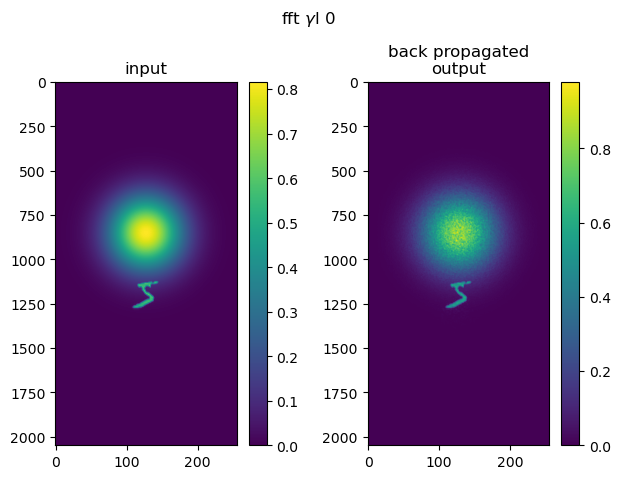

In [14]:
plt.rc('font', size=10)
plt.suptitle( prdata['mode'] +' $\gamma$l '+str(prdata['gl']))
plt.subplot(1,2,1)
plt.imshow(abs(amp0),aspect=ysamp*xaper/(yaper*xsamp))
plt.title("input")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(abs(amp),aspect=ysamp*xaper/(yaper*xsamp))
plt.colorbar()
plt.title("back propagated\noutput")
plt.tight_layout()
plt.show()

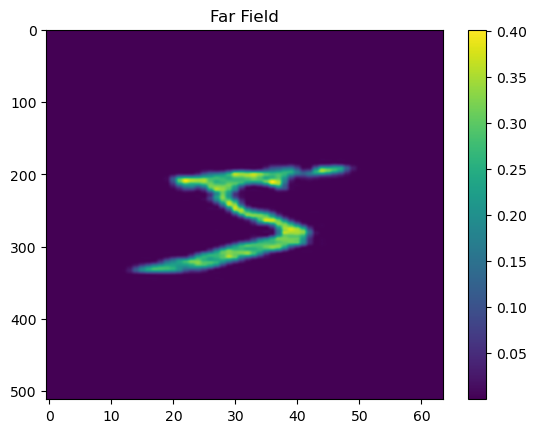

In [15]:
plt.imshow(imout,aspect='auto')
plt.title('Far Field')
plt.colorbar()

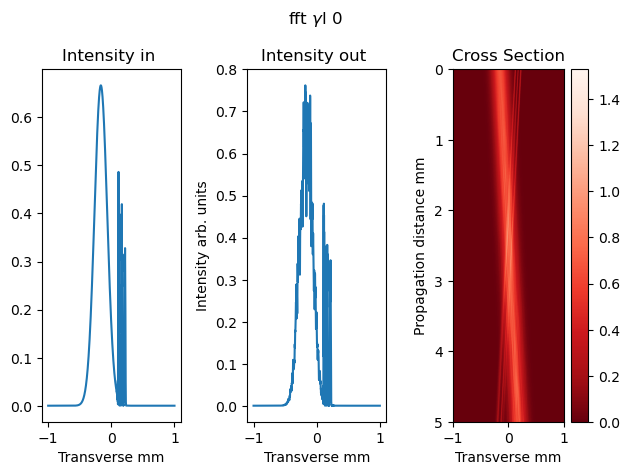

In [16]:
plt.suptitle('Nonparaxial Finite Difference Beam Propagation' +' $\gamma$l '+str(prdata['gl']))
plt.suptitle( prdata['mode'] +' $\gamma$l '+str(prdata['gl']))
plt.subplot(1,3,1)
plt.plot(x/1000,abs(amp0[:,ysamp//2])**2)
plt.xlabel('Transverse mm')
plt.title('Intensity in ')
plt.subplot(1,3,2)
plt.plot(x/1000,abs(amp[:,ysamp//2])**2)
plt.xlabel('Transverse mm')
plt.ylabel('Intensity arb. units')
plt.title('Intensity out ')
plt.subplot(1,3,3)
plt.imshow(intensxz,aspect='auto',cmap='Reds_r',extent=[-xaper/2000,xaper/2000,rlen/1000,0])
plt.xlabel('Transverse mm')
plt.ylabel('Propagation distance mm')
plt.colorbar()
plt.title('Cross Section')
plt.tight_layout()
plt.show()


In [17]:
fp=np.append(np.zeros((xsamp//2,ysamp)),np.ones((xsamp//2,ysamp)),axis=0)
fm=np.append(np.ones((xsamp//2,ysamp)),np.zeros((xsamp//2,ysamp)),axis=0)

ftamp=abs(np.fft.fftshift(np.fft.fft2(amp)))
ftampp=abs(np.fft.fft2(amp)*fp)
ftampm=abs(np.fft.fft2(amp)*fm)
ftamp0p=abs(np.fft.fft2(amp0)*fp)
ftamp0m=abs(np.fft.fft2(amp0)*fm)


ampp=np.fft.ifft2(np.fft.fft2(amp)*fp)
ampm=np.fft.ifft2(np.fft.fft2(amp)*fm)
amp0p=np.fft.ifft2(np.fft.fft2(amp0)*fp)
amp0m=np.fft.ifft2(np.fft.fft2(amp0)*fm)

In [18]:
(np.sum(ftampp**2)+np.sum(ftampm**2))/(np.sum(ftamp0p**2)+np.sum(ftamp0m**2)) # energy conservation check

0.9994809335925164

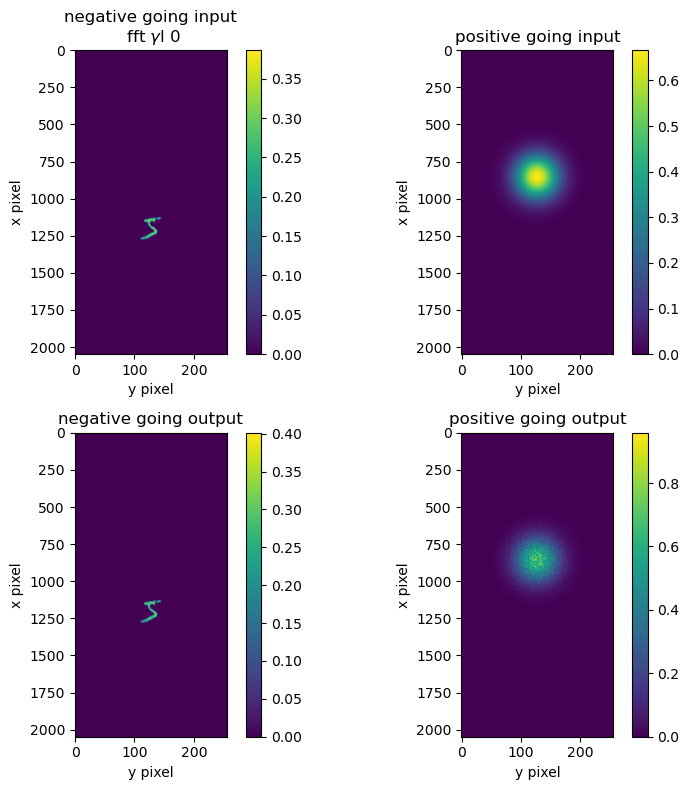

In [19]:
# plot results for beam 1 and 2 separately, as separated by angle of propagation
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(abs(amp0p)**2, aspect=ysamp*xaper/(yaper*xsamp))
plt.colorbar()

plt.title('negative going input\n '+prdata['mode']+ ' $\gamma$l '+str(prdata['gl']))
plt.xlabel('y pixel')
plt.ylabel('x pixel')
plt.subplot(2,2,2)
plt.imshow((abs(amp0m)**2), aspect=ysamp*xaper/(yaper*xsamp))
plt.colorbar()
plt.title('positive going input')
plt.xlabel('y pixel')
plt.ylabel('x pixel')

plt.subplot(2,2,3)
plt.imshow(abs(ampp**2), aspect=ysamp*xaper/(yaper*xsamp))
plt.colorbar()
#plt.clim(0,.004)
plt.title('negative going output')
plt.xlabel('y pixel')
plt.ylabel('x pixel')
plt.subplot(2,2,4)
plt.imshow((abs(ampm**2)), aspect=ysamp*xaper/(yaper*xsamp))
plt.colorbar()
#plt.clim(0,.85)
plt.title('positive going output')
plt.xlabel('y pixel')
plt.ylabel('x pixel')

plt.tight_layout()

plt.show()

In [20]:
xm_out=x[np.argmax(abs(ampm[:,ysamp//2]))]
xp_out=x[np.argmax(abs(ampp[:,ysamp//2]))]
xm_in=x[np.argmax(abs(amp0m[:,ysamp//2]))]
xp_in=x[np.argmax(abs(amp0p[:,ysamp//2]))]

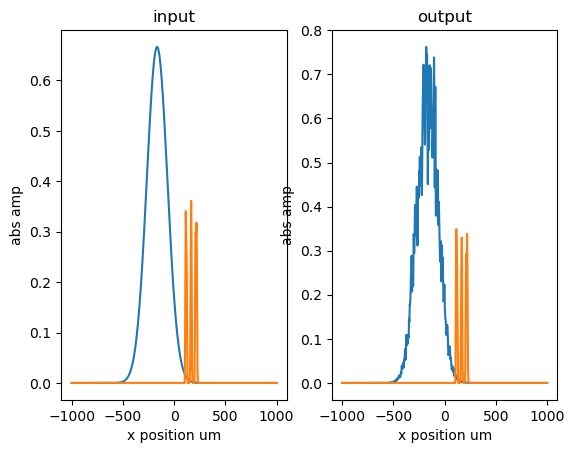

In [21]:
plt.subplot(1,2,1)
plt.plot(x,abs(amp0m[:,ysamp//2])**2)
plt.plot(x,abs(amp0p[:,ysamp//2])**2)
plt.title('input')
plt.xlabel('x position um')
plt.ylabel('abs amp')
plt.subplot(1,2,2)
plt.plot(x,abs(ampm[:,ysamp//2])**2)
plt.plot(x,abs(ampp[:,ysamp//2])**2)
plt.title('output')
plt.xlabel('x position um')
plt.ylabel('abs amp')
plt.show()





In [22]:
gain=0.5*np.log(np.sum(ftampp**2)/np.sum(ftamp0p**2)/(np.sum(ftampm**2)/np.sum(ftamp0m**2)))

In [23]:
gain #estimate of photorefractive gain (for gaussian beams) tramsp1, transp2 False

-3.5476940346045673e-06

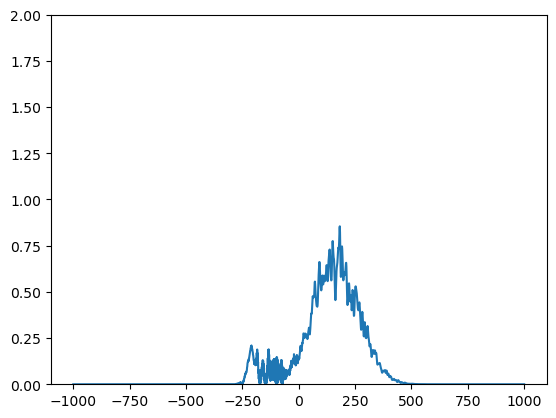

In [24]:
fig, ax = plt.subplots()

#x = range(prdata['xsamp'])
sc=len(intensxz[:,0])  #niter

line, = ax.plot(x, (intensxz[sc//2,:]))
ax.set_ylim([0, 2])
def animate(i):
    line.set_ydata(intensxz2[i,:])  # update the data.
    return line,
ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=sc)
ani
#writervideo = animation.FFMpegWriter(fps=60)
#ani.save('fftgl3.mp4', writer=writervideo)

In [25]:
infilename='audiodigit6464.npz'
np.savez(filepath+infilename,X,y)